In [28]:
import numpy as np
import Backgammon as B
import agent as A
import flipped_agent as FA
import tensorflow as tf
import keras
import keras.layers as L
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [29]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        return moves, np.vstack(boards)
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        out_board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return out_board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [30]:
def get_cumulative_rewards(rewards, gamma = 0.9):
    rewards = np.array(rewards)
    R = np.zeros_like(rewards, dtype= "float32")
    r = 0.
    for i, reward in enumerate(reversed(rewards)):
        r += reward
        R[-(i + 1)] = r
        r *= gamma
        
    return R

In [35]:
# Skilgreina inputs í model
states = tf.placeholder("float32", (None, 29), name = "states")
cumulative_rewards = tf.placeholder("float32", (None, ), name = "cumulative_rewards")

# Skilgreina model (arkitektúrinn skiptir litlu máli þangað til að þjálfunin gengur)
model = keras.models.Sequential()
model.add(L.Dense(32))
model.add(L.LeakyReLU())
model.add(L.Dropout(0.2))
model.add(L.Dense(64))
model.add(L.LeakyReLU())
model.add(L.Dropout(0.2))
model.add(L.Dense(32))
model.add(L.LeakyReLU())
model.add(L.Dense(1))


logits = model(states)
policy = tf.nn.softmax(logits, axis = 0)
log_policy = tf.nn.log_softmax(logits, axis = 0)

entropy = tf.reduce_sum(tf.multiply(policy, log_policy), 1, name = "entropy")

loss = -tf.reduce_sum(log_policy * cumulative_rewards)


# Að maximiza J er það sama og að minimiza -J
all_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
optimizer = tf.train.AdamOptimizer()
update = optimizer.minimize(loss, var_list = all_weights)

In [36]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

/Users/bgautijonsson/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Win percentage:  0.88


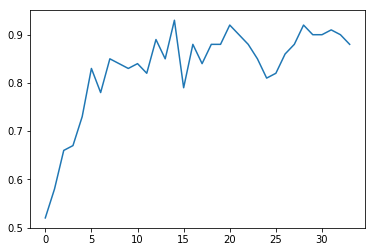

KeyboardInterrupt: 

In [37]:
win_pct = []

for i in range(1000):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        rewards = []
        boards = []
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                action_probs = s.run(policy, ({states: possible_boards})).reshape(n_actions)
                action = np.random.choice(n_actions, p = action_probs)
                old_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                boards.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for __ in range(1 + int(dice[0] == dice[1])):
                        old_state, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break
            
        X = np.vstack(boards)
        y = get_cumulative_rewards(rewards)

        s.run(update, ({states: X, cumulative_rewards: y}))
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    